# **Time series forecasting with statistical approach**

---



## 1. Import libraries, repositories, and data

In [1]:
import numpy as np
import scipy.fftpack
import scipy.io
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from ESN import esnet
import json
from sklearn.decomposition import PCA
%matplotlib inline

Let's load the time series data of electricity load and plot them. 
Data are sampled every 10 minutes.

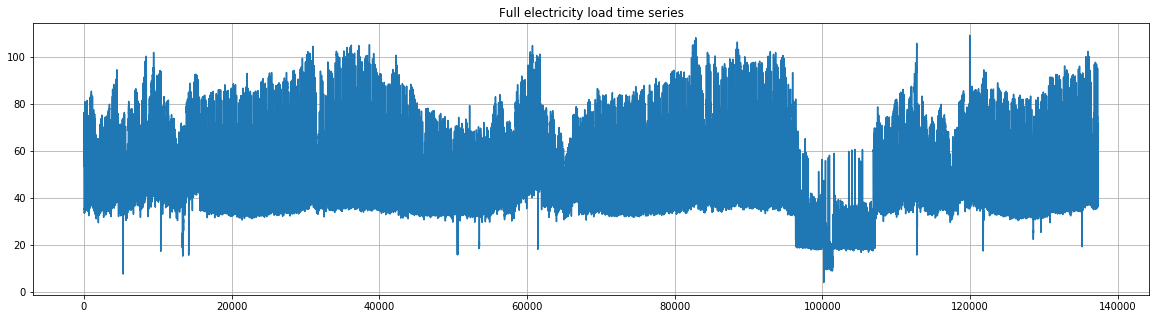

In [4]:
ts_full = scipy.io.loadmat("TS_Acea.mat")["X"]
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(ts_full)
plt.grid()
plt.title("Full electricity load time series")
plt.show()

For this example, we will use a small portion of the whole dataset, for illustration purpose

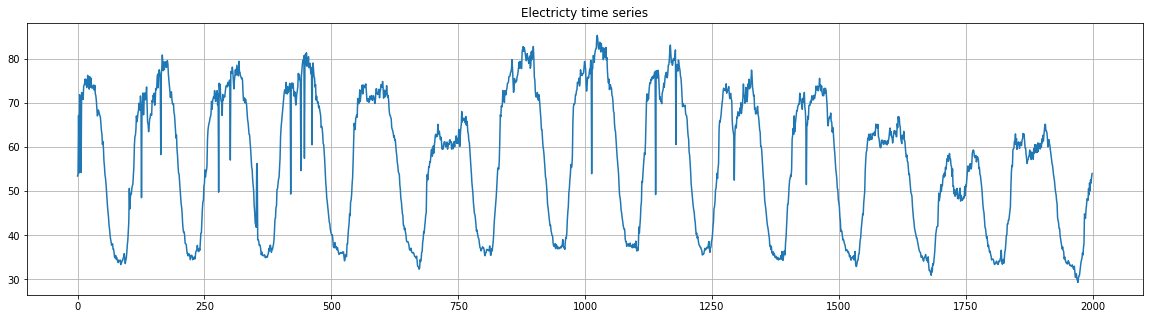

In [5]:
N = 2000
ts = ts_full[:N,0]

plt.plot(ts)
plt.grid()
plt.title("Electricty time series")
plt.show()

## 2. Remove trend, seasonality, and short-term correlations

**Autocorrelation function.** The blue area is the confidence interval, setby default to a 95%. Values outside the blue area are very likely a correlation and not a statistical fluke.

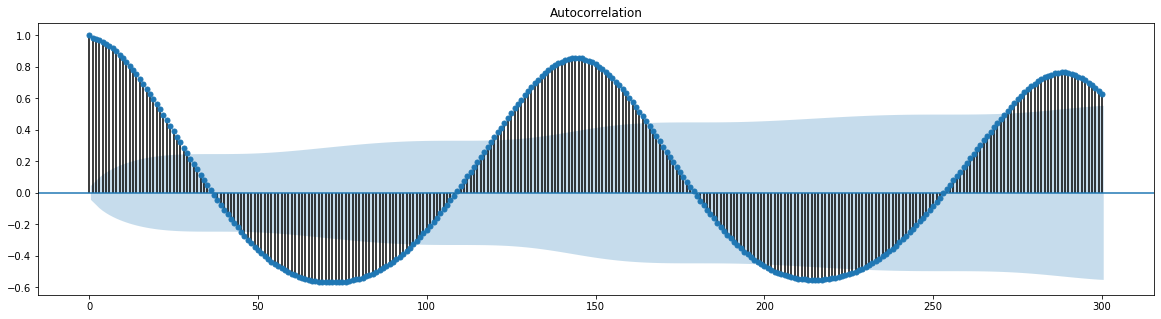

In [6]:
plt.figure(figsize=(20,5))
ax = plt.gca()
plot_acf(ts, lags=300, ax=ax) 
plt.show()

Find **trend** with linear fit

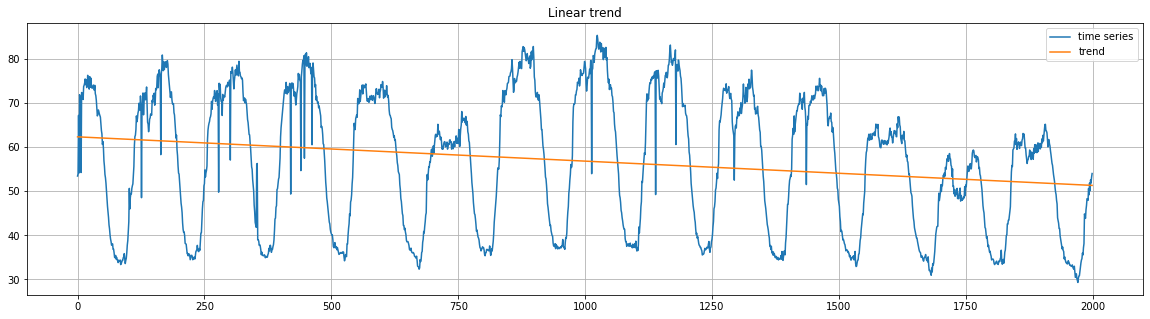

In [7]:
poly_coeff = np.polyfit(np.asarray(np.arange(ts.shape[0])), ts, deg=1)
poly = np.poly1d(poly_coeff)
trend = poly(np.linspace(1, N, N))

plt.plot(ts, label="time series")
plt.plot(trend, label="trend")
plt.title("Linear trend")
plt.legend()
plt.grid()
plt.show()

Remove linear trend and check again the new trend after removal

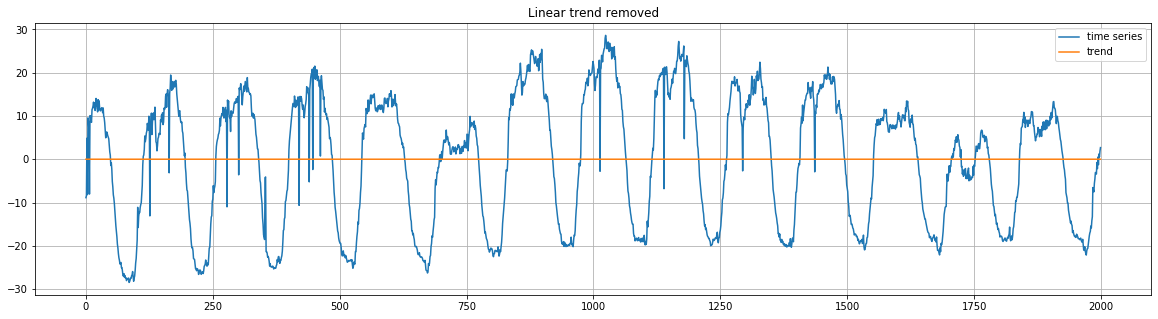

In [8]:
ts_detrend = ts - trend 
poly_coeff = np.polyfit(np.asarray(np.arange(ts.shape[0])), ts_detrend, deg=1)
poly = np.poly1d(poly_coeff)
trend = poly(np.linspace(1, N, N))

plt.plot(ts_detrend, label="time series")
plt.plot(trend, label="trend")
plt.title("Linear trend removed")
plt.legend()
plt.grid()
plt.show()

Find main seasonality with Fourier transform

Main seasonality: 143


C:\Users\fmbia\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


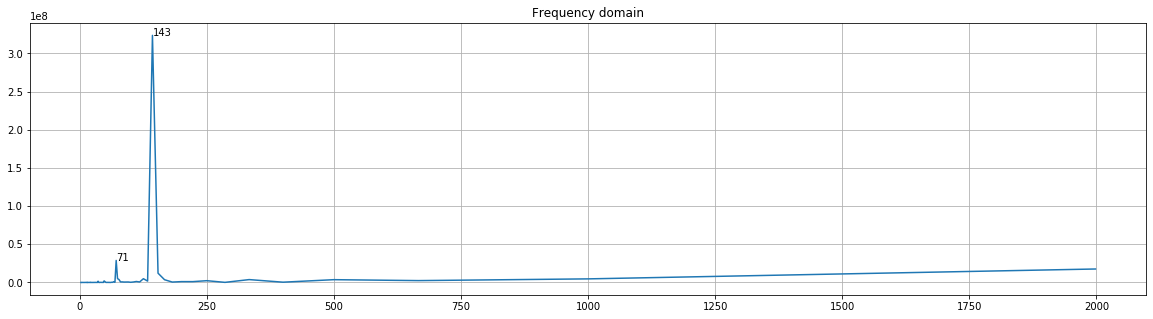

In [9]:
ft = scipy.fftpack.fft(ts_detrend)
power = np.abs(ft[:N//2])**2
nyquist = 1.0/2.0
freq = np.linspace(0, 1, N//2)*nyquist
period = 1.0/freq

main_seas = np.round(period[np.argmax(power)]).astype(np.int)
print("Main seasonality: %d"% main_seas)

plt.plot(period, power)
maxima = np.argsort(-power)[:2] # get the first two maxima
x_annot = np.round(period[maxima[0]]).astype(np.int)
y_annot = power[maxima[0]]
plt.annotate(x_annot, xy=(x_annot, y_annot ) )
x_annot = np.round(period[maxima[1]]).astype(np.int)
y_annot = power[maxima[1]]
plt.annotate(x_annot, xy=(x_annot, y_annot ) )
plt.title("Frequency domain")
plt.grid()
plt.show()

Remove seasonality with seasonal differencing

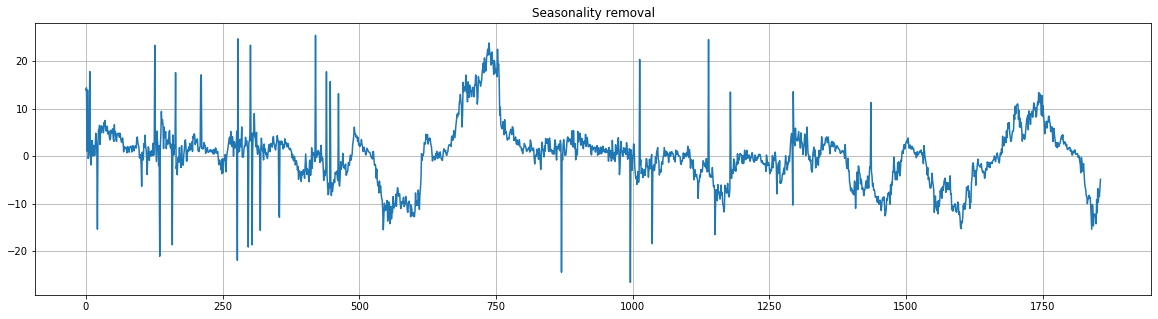

In [10]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.asarray(diff)

ts_deseas = difference(ts_detrend, interval=main_seas)
plt.plot(ts_deseas)
plt.title("Seasonality removal")
plt.grid()
plt.show()

Remove short-term correlation with 1st order differencing

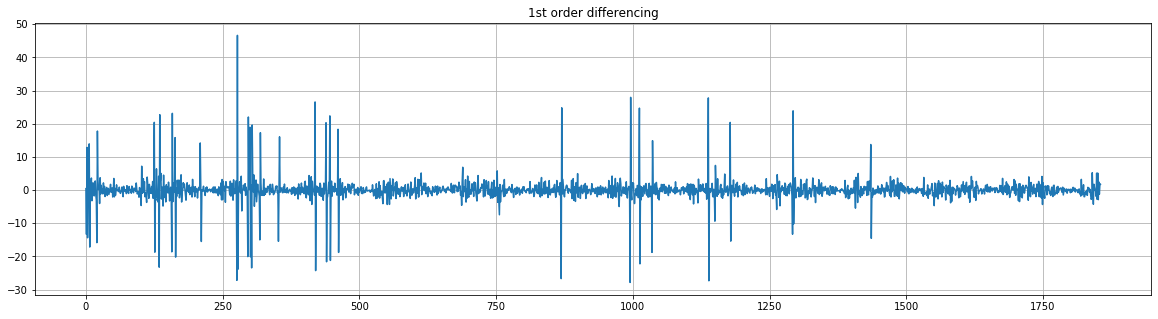

In [11]:
lag_diff = 1
ts_diff = difference(ts_deseas, interval=lag_diff)
plt.plot(ts_diff)
plt.title("1st order differencing")
plt.grid()
plt.show()

Check again the ACF

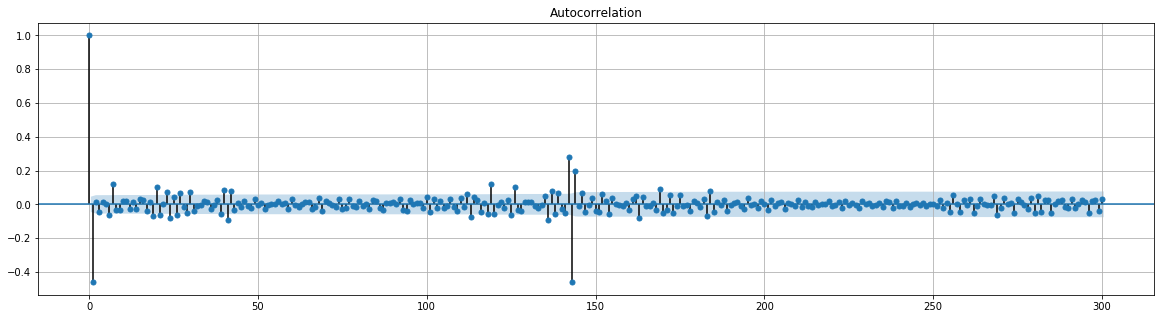

In [12]:
plot_acf(ts_diff, lags=300) 
plt.grid()
plt.show()

## 3. Forecasting with an AR model

Predict the last 500 time steps of the time series. Prediction is 1 step ahead (10 minutes).

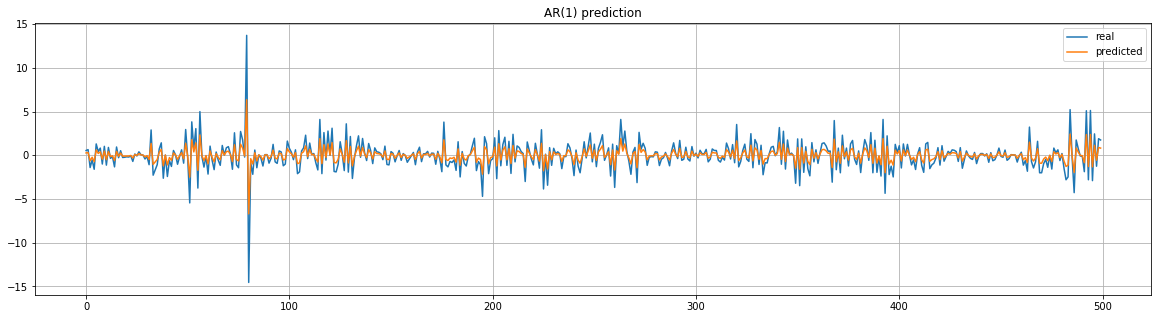

In [13]:
window = 500 # specify the size of the prediction window
mod = ARMA(ts_diff, order=(1,0)) # specify the ARMA model (in this case AR(1) and no MA part)
fit_mod = mod.fit() # Fit the model (optimize parameters)
pred = fit_mod.predict(start=ts_diff.shape[0]-window+1, end=ts_diff.shape[0])*-1.0 # Compute predictions 
plt.plot(ts_diff[ts_diff.shape[0]-window:ts_diff.shape[0]], label="real")
plt.plot(pred, label="predicted")
plt.legend()
plt.grid()
plt.title("AR(1) prediction")
plt.show()

Revert the differentiations to get the actual values

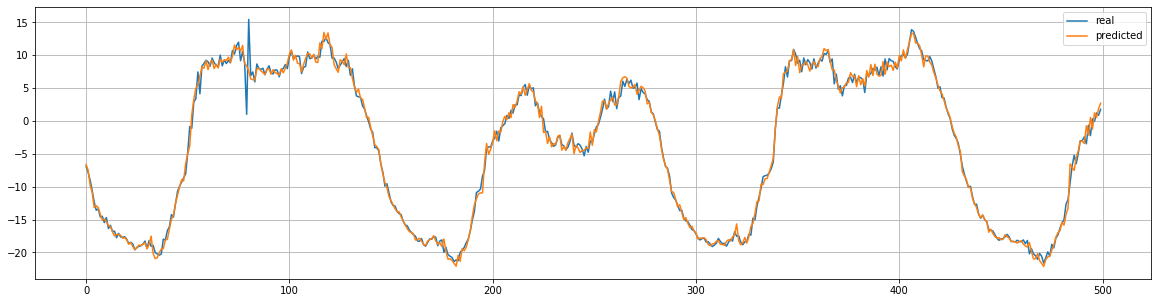

In [14]:
def revert_difference(dataset, diff_dataset):
    rev = [dataset[i] + diff_dataset[i] for i in range(diff_dataset.shape[0])]
    rev = np.array(rev)
    return rev

# Substitute predicted values
ts_diff[ts_diff.shape[0]-window:ts_diff.shape[0]] = pred

# Revert differentiations and draw plots
ts_revert = revert_difference(ts_deseas, ts_diff)
ts_revert = revert_difference(ts_detrend[lag_diff:], ts_revert)
plt.plot(ts_revert[-window:], label="real")
plt.plot(ts_detrend[-window:], label="predicted")
plt.legend()
plt.grid()
plt.show()